# **Restaurant revenue forecast**

In this notebook, we have code that builds a deep learning regression model that predicts monthly revenue for a restaurant. 

#### Notebook structure (**follows CRISP-DM framework**)

1. Business value<br>
2. Exploatory Data Analysis<br>
3. Data Selection<br>
4. Feature selection<br>
5. Modellingt<br>
6. Evaluation<br>

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

# <label style="color:blue">Part I : Business understanding</label>
Forecasting business mertics is very important for all businesses. I helps businesses be proactive. 
Imagine you know next month your business : <br/><br/>
`1`. is not going to make profit,meaning you are going to make a loss, <br/><br/>
`2`. with that knowledge you can react proactively by putting campaigns that are going to help you avoid running a loss. 

In [25]:
# import all the libraries
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import pandas as pd 
import seaborn as sns
from scipy.stats import skew
import warnings
import pickle
import numpy as np
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import pearsonr
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    explained_variance_score, median_absolute_error
)
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [26]:
#read data from csv to dataframe
restaurant_data = pd.read_csv("Restaurant_revenue.csv")

# <label style="color:blue" id="Exploratory-Data-Analysis">Part II :Data understanding (Exploratory Data Analysis)</label>


`1.` What is the distribution of all numeric variables?  <br/>
`2.` What is the distribution of our target variable, monthly revenue? <br/>
`3.` What is the distribution of customer spending, menu price, and number of customer? <br/>
`4.` What is the statistical attributes of the data looking at numerical columns? 

In [27]:
#check data dimensions
restaurant_data.shape

(1000, 8)

In [28]:
#check columns and their datatypes
restaurant_data.dtypes

Number_of_Customers            int64
Menu_Price                   float64
Marketing_Spend              float64
Cuisine_Type                  object
Average_Customer_Spending    float64
Promotions                     int64
Reviews                        int64
Monthly_Revenue              float64
dtype: object

In [29]:
#show data statistical attributes
restaurant_data.describe()

Number_of_Customers   Menu_Price  Marketing_Spend  \
count          1000.000000  1000.000000      1000.000000   
mean             53.271000    30.219120         9.958726   
std              26.364914    11.278760         5.845586   
min              10.000000    10.009501         0.003768   
25%              30.000000    20.396828         4.690724   
50%              54.000000    30.860614        10.092047   
75%              74.000000    39.843868        14.992436   
max              99.000000    49.974140        19.994276   

       Average_Customer_Spending   Promotions      Reviews  Monthly_Revenue  
count                1000.000000  1000.000000  1000.000000      1000.000000  
mean                   29.477085     0.497000    49.837000       268.724172  
std                    11.471686     0.500241    29.226334       103.982950  
min                    10.037177     0.000000     0.000000       -28.977809  
25%                    19.603041     0.000000    24.000000       197.103642  
50%                    29.251365     0.000000    50.000000       270.213964  
75%                    39.553220     1.000000    76.000000       343.395793  
max                    49.900725     1.000000    99.000000       563.381332

In [30]:
#show cuisine type distributions
restaurant_data.Cuisine_Type.value_counts()

Japanese    262
American    256
Mexican     250
Italian     232
Name: Cuisine_Type, dtype: int64

In [31]:
#show Promotions distributions
restaurant_data.Promotions.value_counts()

0    503
1    497
Name: Promotions, dtype: int64

<Figure size 1200x400 with 0 Axes>

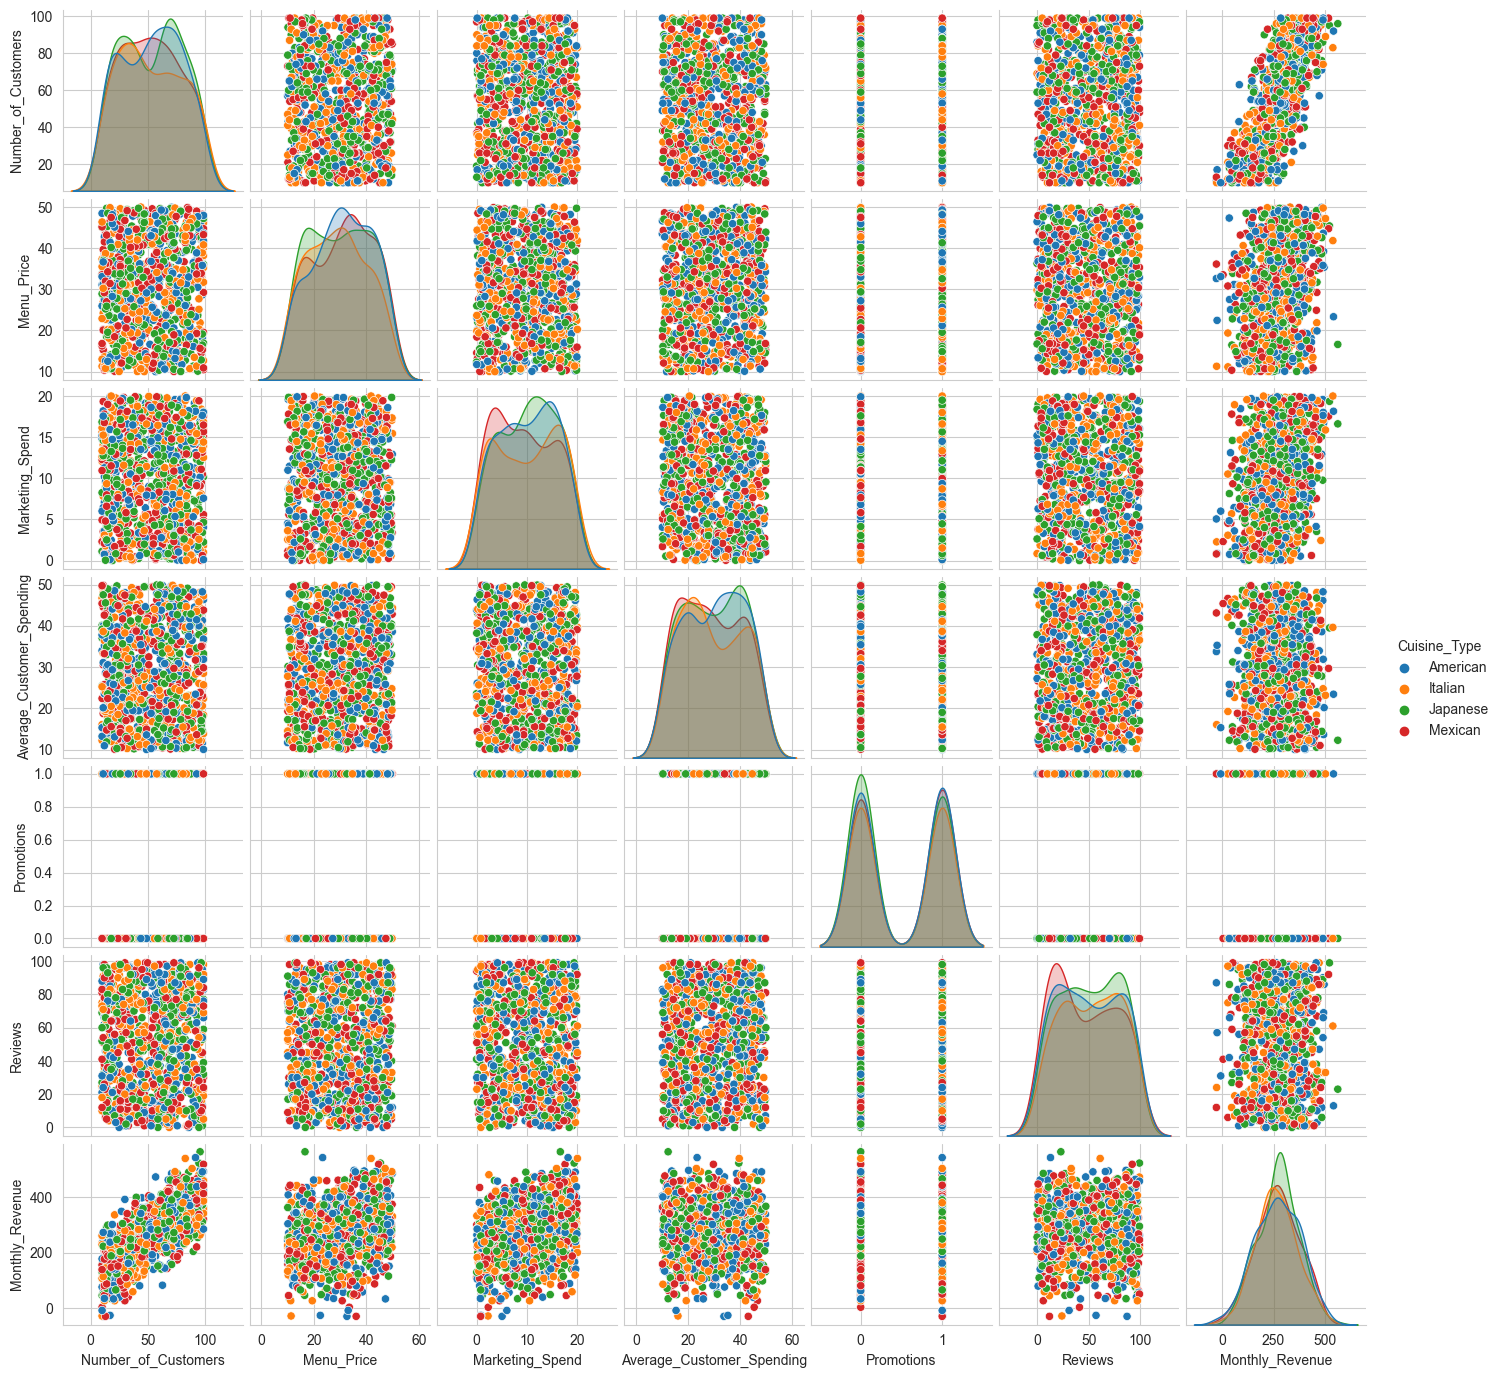

In [32]:
# show variable relationships and distributions having hue as cuisine type
restaurant_data = restaurant_data.loc[:, ~restaurant_data.columns.duplicated()]
required_columns = ['Number_of_Customers', 'Menu_Price', 'Marketing_Spend', 'Average_Customer_Spending', 'Promotions', 'Reviews','Monthly_Revenue','Cuisine_Type']
missing_columns = [col for col in required_columns if col not in restaurant_data.columns]
if missing_columns:
    raise ValueError(f"Missing columns in DataFrame: {missing_columns}")
training_data_cleaned = restaurant_data.dropna(subset=required_columns)
training_data_cleaned['Cuisine_Type'] = training_data_cleaned['Cuisine_Type'].astype('category')
plt.figure(figsize=(12, 4))
sns.set_style('whitegrid')
sns.pairplot(training_data_cleaned[required_columns], height=2, hue='Cuisine_Type')
plt.show()


<Figure size 1200x400 with 0 Axes>

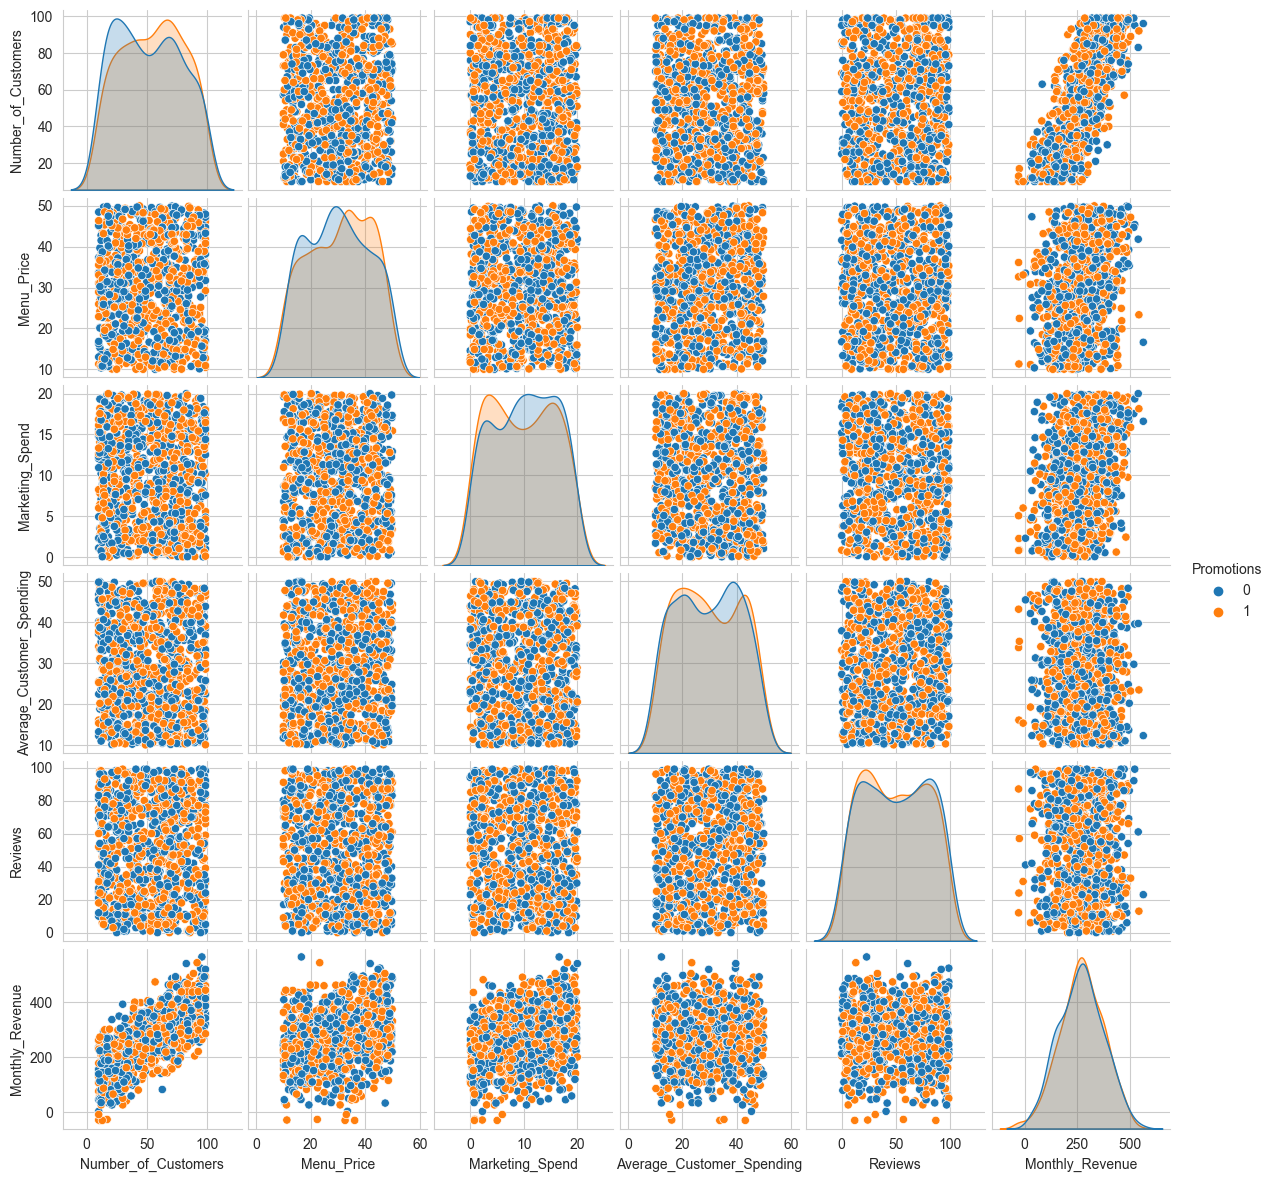

In [33]:
# show variable relationships and distributions having hue as promotion
restaurant_data = restaurant_data.loc[:, ~restaurant_data.columns.duplicated()]
required_columns = ['Number_of_Customers', 'Menu_Price', 'Marketing_Spend', 'Average_Customer_Spending', 'Promotions', 'Reviews','Monthly_Revenue','Cuisine_Type']
missing_columns = [col for col in required_columns if col not in restaurant_data.columns]
if missing_columns:
    raise ValueError(f"Missing columns in DataFrame: {missing_columns}")
training_data_cleaned = restaurant_data.dropna(subset=required_columns)
training_data_cleaned['Promotions'] = training_data_cleaned['Promotions'].astype('category')
plt.figure(figsize=(12, 4))
sns.set_style('whitegrid')
sns.pairplot(training_data_cleaned[required_columns], height=2, hue='Promotions',)
plt.show()

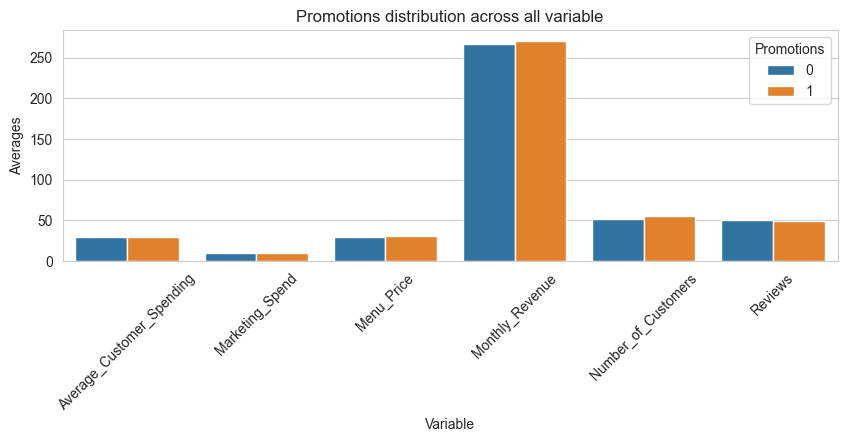

In [34]:
# show variable means having hue as promotion
plt.figure(figsize=(10, 3))
df_melted = restaurant_data.melt(id_vars='Promotions', value_vars=['Number_of_Customers', 'Menu_Price', 'Marketing_Spend', 'Average_Customer_Spending', 'Reviews','Monthly_Revenue'], var_name='variable', value_name='value')
mean_values = df_melted.groupby(['variable', 'Promotions']).mean().reset_index()
sns.barplot(data=mean_values, x='variable', y='value', hue='Promotions')
plt.xlabel('Variable')
plt.ylabel('Averages')
plt.title('Promotions distribution across all variable')
plt.xticks(rotation=45)
plt.show()

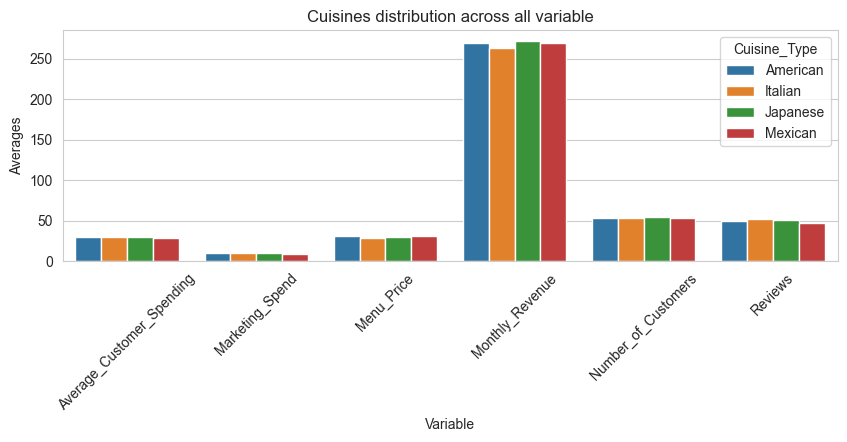

In [35]:
# show variable means having hue as cuisine type
plt.figure(figsize=(10, 3))
df_melted = restaurant_data.melt(id_vars='Cuisine_Type', value_vars=['Number_of_Customers', 'Menu_Price', 'Marketing_Spend', 'Average_Customer_Spending', 'Reviews','Monthly_Revenue'], var_name='variable', value_name='value')
mean_values = df_melted.groupby(['variable', 'Cuisine_Type']).mean().reset_index()
sns.barplot(data=mean_values, x='variable', y='value', hue='Cuisine_Type')
plt.xlabel('Variable')
plt.ylabel('Averages')
plt.title('Cuisines distribution across all variable')
plt.xticks(rotation=45)
plt.show()

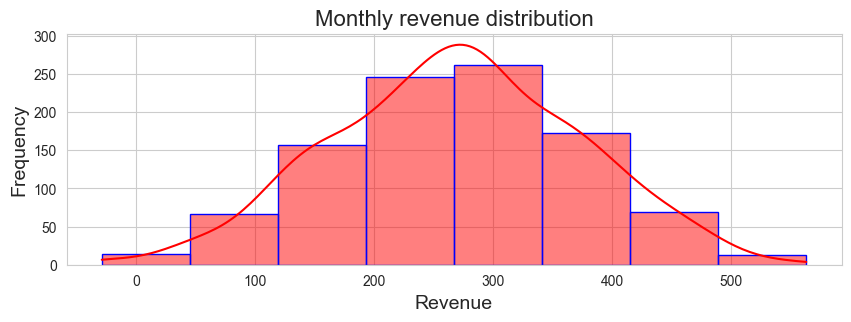

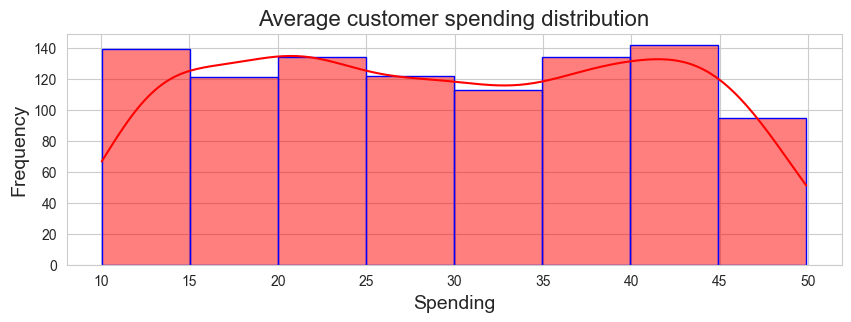

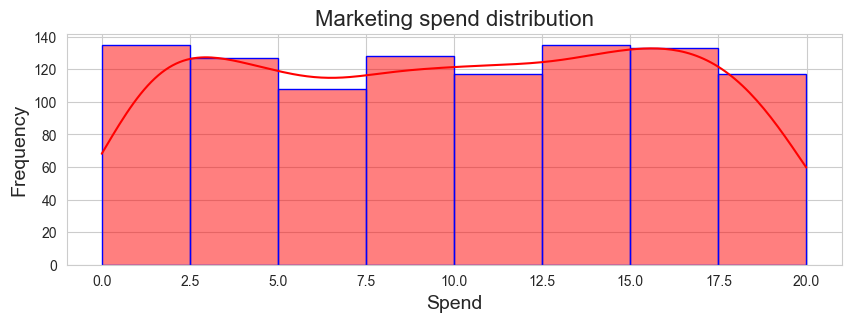

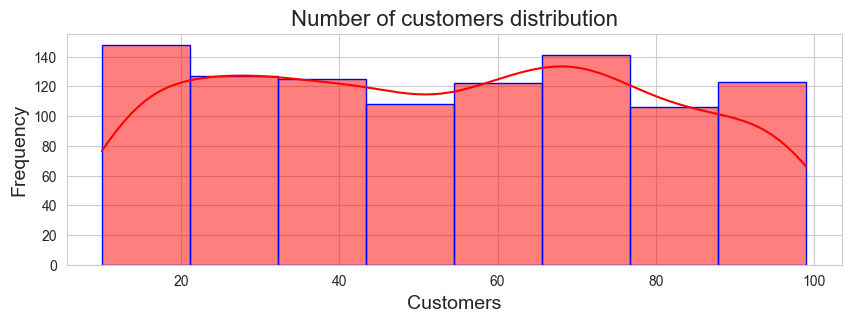

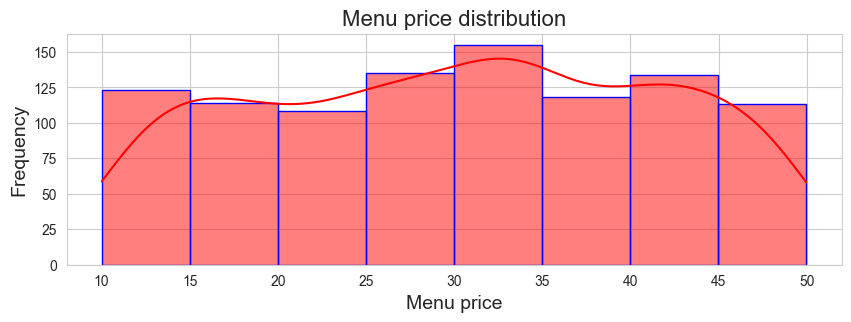

In [36]:
# show variables distribution


# Creating the histogram with Seaborn
plt.figure(figsize=(10, 3))
sns.histplot(list(restaurant_data['Monthly_Revenue']), bins=8, kde=True, color='red', edgecolor='blue')
plt.title('Monthly revenue distribution', fontsize=16)
plt.xlabel('Revenue', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


# Creating the histogram with Seaborn
plt.figure(figsize=(10, 3))
sns.histplot(list(restaurant_data['Average_Customer_Spending']), bins=8, kde=True, color='red', edgecolor='blue')
plt.title('Average customer spending distribution', fontsize=16)
plt.xlabel('Spending', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


# Creating the histogram with Seaborn
plt.figure(figsize=(10, 3))
sns.histplot(list(restaurant_data['Marketing_Spend']), bins=8, kde=True, color='red', edgecolor='blue')
plt.title('Marketing spend distribution', fontsize=16)
plt.xlabel('Spend', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


# Creating the histogram with Seaborn
plt.figure(figsize=(10, 3))
sns.histplot(list(restaurant_data['Number_of_Customers']), bins=8, kde=True, color='red', edgecolor='blue')
plt.title('Number of customers distribution', fontsize=16)
plt.xlabel('Customers', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# Creating the histogram with Seaborn
plt.figure(figsize=(10, 3))
sns.histplot(list(restaurant_data['Menu_Price']), bins=8, kde=True, color='red', edgecolor='blue')
plt.title('Menu price distribution', fontsize=16)
plt.xlabel('Menu price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# <label style="color:blue" id="Exploratory-Data-Analysis">Part III : Data preparation</label>

In [37]:
def missing_value_percentages(df):
    """
    Calculate the percentage of missing values in each column of the DataFrame.

    Parameters:
    - df (pandas DataFrame): The DataFrame for which missing values percentages are calculated.

    Returns:
    - pandas DataFrame: A DataFrame containing two columns:
        - 'column_name': The name of each column in the input DataFrame.
        - 'percent_missing': The percentage of missing values in each column.
    """
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df


In [38]:
#ceating a dataframe that column and missing values percentage
cust_data_missing = missing_value_percentages(restaurant_data)

In [39]:
cust_data_missing

column_name  percent_missing
Number_of_Customers              Number_of_Customers              0.0
Menu_Price                                Menu_Price              0.0
Marketing_Spend                      Marketing_Spend              0.0
Cuisine_Type                            Cuisine_Type              0.0
Average_Customer_Spending  Average_Customer_Spending              0.0
Promotions                                Promotions              0.0
Reviews                                      Reviews              0.0
Monthly_Revenue                      Monthly_Revenue              0.0

In [40]:
def skewness_detector(dataset, col):
    """
    Detect the skewness of a specified column in a dataset.

    Parameters:
    - dataset (pandas DataFrame): The dataset containing the column.
    - col (str): The name of the column for which skewness is to be detected.

    Returns:
    - str: A string indicating the skewness of the column's distribution:
        - "left-skewed" if the distribution is left-skewed.
        - "right-skewed" if the distribution is right-skewed.
        - "symmetrical" if the distribution is symmetrical.
    """
    skewness = skew(dataset[col])
    if skewness > 0:
        return "right-skewed"
    elif skewness < 0:
        return "left-skewed"
    else:
        return "symmetrical"

In [41]:
# extracting numerical columns from the dataframe
numeric_columns = restaurant_data.select_dtypes(include=['number']).columns

In [42]:
print(list(numeric_columns))

['Number_of_Customers', 'Menu_Price', 'Marketing_Spend', 'Average_Customer_Spending', 'Promotions', 'Reviews', 'Monthly_Revenue']


In [43]:
# determining columns skewness
cols_skewness = pd.DataFrame()
for column in numeric_columns:
    skewness = skewness_detector(restaurant_data,column)
    row = {'column':column,'skewness':skewness}
    cols_skewness = cols_skewness.append(row, ignore_index=True)
cols_skewness

column      skewness
0        Number_of_Customers  right-skewed
1                 Menu_Price   left-skewed
2            Marketing_Spend   left-skewed
3  Average_Customer_Spending  right-skewed
4                 Promotions  right-skewed
5                    Reviews  right-skewed
6            Monthly_Revenue   left-skewed

In [44]:
def remove_outliers_iqr(data_frame, cols):
    """
    Remove outliers from the specified columns of a DataFrame using the Interquartile Range (IQR) method.

    Parameters:
    - data_frame (pandas DataFrame): The DataFrame containing the data.
    - cols (list of str): A list of column names from which outliers should be removed.

    Returns:
    - pandas DataFrame: A DataFrame with outliers removed from the specified columns.
    """
    cleaned_df = data_frame.copy()
    for column_name in cols:
        Q1 = cleaned_df[column_name].quantile(0.25)
        Q3 = cleaned_df[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cleaned_df = cleaned_df[(cleaned_df[column_name] >= lower_bound) & (cleaned_df[column_name] <= upper_bound)]
    return cleaned_df


In [45]:
#creating a dataframe where outliers are removed
restaurant_data_wou = remove_outliers_iqr(restaurant_data,numeric_columns)

In [46]:
# showing statistical attributes of our data when outlier are removed
restaurant_data_wou = restaurant_data_wou[restaurant_data_wou.Monthly_Revenue>=0]
restaurant_data_wou.describe()

Number_of_Customers  Menu_Price  Marketing_Spend  \
count           994.000000  994.000000       994.000000   
mean             53.434608   30.248379         9.987001   
std              26.247184   11.283711         5.836555   
min              10.000000   10.009501         0.003768   
25%              31.000000   20.443839         4.704846   
50%              54.000000   30.860614        10.160257   
75%              74.000000   39.904905        14.995489   
max              99.000000   49.974140        19.994276   

       Average_Customer_Spending  Promotions     Reviews  Monthly_Revenue  
count                 994.000000  994.000000  994.000000       994.000000  
mean                   29.498219    0.494970   49.902414       269.898773  
std                    11.466233    0.500226   29.235191       101.774306  
min                    10.037177    0.000000    0.000000         3.819308  
25%                    19.676892    0.000000   24.000000       199.160139  
50%                    29.251365    0.000000   50.000000       270.527956  
75%                    39.560178    1.000000   76.000000       343.461651  
max                    49.900725    1.000000   99.000000       542.467282

In [47]:
# dropping duplicates
has_duplicates = restaurant_data_wou.duplicated().any()

if has_duplicates:
    print("DataFrame has duplicates.")
else:
    print("DataFrame has no duplicates.")

# Get duplicate counts
duplicate_counts = restaurant_data_wou.duplicated().sum()

print("Number of duplicate rows:", duplicate_counts)
restaurant_data_wou = restaurant_data_wou.drop_duplicates()

DataFrame has no duplicates.
Number of duplicate rows: 0


In [48]:
#applying onehot encoding on nominal variable
restaurant_data_wou = pd.get_dummies(restaurant_data_wou, columns=['Cuisine_Type']) 

# <label style="color:blue" id="Exploratory-Data-Analysis">Part IV : Feature selection</label>

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

# Assigning target and predictor variables
X = restaurant_data_wou.drop(columns=['Monthly_Revenue'])
y = restaurant_data_wou['Monthly_Revenue']
feature_names = X.columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def variance_threshold_selector(data, threshold=0.01):
    """
    Perform feature selection based on variance thresholding.

    Parameters:
    - data (array-like or sparse matrix): The input data.
    - threshold (float, optional): The threshold below which features will be removed. 
                                   Features with a variance lower than this threshold will be removed.
                                   Default is 0.01.

    Returns:
    - tuple: A tuple containing two elements:
        - Transformed data after removing features with low variance.
        - Indices of the selected features.
    """
    selector = VarianceThreshold(threshold)
    return selector.fit_transform(data), selector.get_support(indices=True)


# Apply Variance Threshold to the training and testing sets
X_train_var, selected_indices_var = variance_threshold_selector(X_train, threshold=0.01)
X_test_var = X_test.iloc[:, selected_indices_var].values  # Apply same indices to test set

# Update feature names after Variance Threshold
feature_names_var = feature_names[selected_indices_var]

def correlation_coefficient_selector(X, y, threshold=0.2):
    """
    Select features based on their correlation coefficient with the target variable.

    Parameters:
    - X (array-like): The feature matrix.
    - y (array-like): The target variable.
    - threshold (float, optional): The threshold for selecting features based on correlation coefficient.
                                   Default is 0.2.

    Returns:
    - list: A list containing the indices of the selected features.
    """
    selected_features = []
    for i in range(X.shape[1]):
        corr, _ = pearsonr(X[:, i], y)
        if abs(corr) >= threshold:
            selected_features.append(i)
    return selected_features

# Get the selected feature indices based on correlation coefficient
selected_features_corr = correlation_coefficient_selector(X_train_var, y_train, threshold=0.2)

# Reduce data to selected features
X_train_selected = X_train_var[:, selected_features_corr]
X_test_selected = X_test_var[:, selected_features_corr]

# Update feature names after Correlation Coefficient
feature_names_selected = feature_names_var[selected_features_corr]
print(f'Selected Feature Names: {list(feature_names_selected)}')

# Standardize the predictors
scaler = StandardScaler()
X_train_selected_normalized = X_train_selected
X_test_selected_normalized = X_test_selected

Selected Feature Names: ['Number_of_Customers', 'Menu_Price', 'Marketing_Spend']


# <label style="color:blue" id="Exploratory-Data-Analysis">Part V : Modelling</label>

In [50]:
# Train MLP Regressor with selected features
mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
mlp.fit(X_train_selected_normalized, y_train)

MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)

# <label style="color:blue" id="Exploratory-Data-Analysis">Part VI : Evaluation</label>

In [51]:
# Predict and evaluate
y_pred = mlp.predict(X_test_selected_normalized)
y_pred_train = mlp.predict(X_train_selected_normalized)

# Calculate evaluation metrics (Test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2) * (len(y_test)-1) / (len(y_test)-X_test_selected_normalized.shape[1]-1)
explained_variance = explained_variance_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)
# Calculate evaluation metrics( Train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
r2_train = r2_score(y_train, y_pred_train)
adjusted_r2_train = 1 - (1-r2_train) * (len(y_pred_train)-1) / (len(y_pred_train)-X_test_selected_normalized.shape[1]-1)
explained_variance_train = explained_variance_score(y_train, y_pred_train)
median_ae_train = median_absolute_error(y_train, y_pred_train)

In [52]:
# assign evaluation metrics for test set
metrics_test = {
    'Mean Squared Error (MSE)': mse,
    'Root Mean Squared Error (RMSE)': rmse,
    'Mean Absolute Error (MAE)': mae,
    'Mean Absolute Percentage Error (MAPE)': mape,
    'R-squared (R2)': r2,
    'Adjusted R-squared (Adj R2)': adjusted_r2,
    'Explained Variance Score': explained_variance,
    'Median Absolute Error (MedAE)': median_ae
}

# assign evaluation metrics for training set
metrics_train = {
    'Mean Squared Error (MSE)': mse_train,
    'Root Mean Squared Error (RMSE)': rmse_train,
    'Mean Absolute Error (MAE)': mae_train,
    'Mean Absolute Percentage Error (MAPE)': mape_train,
    'R-squared (R2)': r2_train,
    'Adjusted R-squared (Adj R2)': adjusted_r2_train,
    'Explained Variance Score': explained_variance_train,
    'Median Absolute Error (MedAE)': median_ae_train
}

# Create DataFrames
df_test = pd.DataFrame(metrics_test, index=[''])
df_train = pd.DataFrame(metrics_train, index=[''])


# Create a DataFrame with both test and training values and their percentage difference
df_combined = pd.concat([df_test, df_train], keys=['Test', 'Train'])


In [53]:
df_combined

Mean Squared Error (MSE)  Root Mean Squared Error (RMSE)  \
Test                 3326.941141                       57.679642   
Train                3267.582853                       57.162775   

        Mean Absolute Error (MAE)  Mean Absolute Percentage Error (MAPE)  \
Test                    46.323182                              34.940775   
Train                   45.637895                              24.674591   

        R-squared (R2)  Adjusted R-squared (Adj R2)  Explained Variance Score  \
Test          0.643278                     0.637790                  0.643572   
Train         0.691659                     0.690489                  0.691663   

        Median Absolute Error (MedAE)  
Test                        42.623780  
Train                       38.166718

#### Hyper parameter tuning

In [54]:
# Hyperparameter tuning for MLPRegressor
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000, 1500]
}

mlp = MLPRegressor(random_state=42)

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_selected_normalized, y_train)

best_mlp = grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [55]:
best_mlp = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_mlp.predict(X_test_selected_normalized)


# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2) * (len(y_test)-1) / (len(y_test)-X_test_selected_normalized.shape[1]-1)
explained_variance = explained_variance_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)

print(f'Selected Feature Names: {list(feature_names_selected)}')
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'R-squared: {r2}')
print(f'Adjusted R-squared: {adjusted_r2}')
print(f'Explained Variance Score: {explained_variance}')
print(f'Median Absolute Error: {median_ae}')

Selected Feature Names: ['Number_of_Customers', 'Menu_Price', 'Marketing_Spend']
Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
Mean Squared Error: 3326.341341968297
Root Mean Squared Error: 57.67444271051344
Mean Absolute Error: 46.523158389708456
Mean Absolute Percentage Error: 35.092928977564426
R-squared: 0.6433426294831626
Adjusted R-squared: 0.6378555930136727
Explained Variance Score: 0.6436999186575716
Median Absolute Error: 43.69629785783036


# <label style="color:blue" id="Exploratory-Data-Analysis">Part VII : Deployment</label>

In [56]:

with open("model_artifact.pkl", 'wb') as file:
        pickle.dump(mlp, file)